# Loading the data

In [1]:
import statistics
import os

import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import networkx as nx
import pickle5 as pickle55

from pyvis.network import Network

from phenopy.build_hpo import generate_annotated_hpo_network
from phenopy.score import Scorer

from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut

2022-01-29 10:44:43,462 - phenopy - INFO - checking if config file exists: /home/sasja/.phenopy
2022-01-29 10:44:43,463 - phenopy - INFO - phenopy 0.5.3
2022-01-29 10:44:43,464 - phenopy - INFO - Using configuration file: /home/sasja/.phenopy/phenopy.ini


In [2]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

file = './data_all.pickle'  
with open(file, "rb") as fh:
      g = pickle55.load(fh)
        
g.head()

,hpo_all,hpo_all_name,graphs,hpo_all_with_parents,hpo_all_name_with_parents,label
0,"[HP:0006579, HP:0001276, HP:0100025, HP:000987...","[Prolonged neonatal jaundice, Hypertonia, Over...","(All, Phenotypic abnormality, Abnormality of h...","[HP:0000001, HP:0000118, HP:0000152, HP:000015...","[All, Phenotypic abnormality, Abnormality of h...",spop_1
1,"[HP:0006579, HP:0002643, HP:0100716, HP:000255...","[Prolonged neonatal jaundice, Neonatal respira...","(All, Functional abnormality of the bladder, A...","[HP:0000001, HP:0000009, HP:0000014, HP:000006...","[All, Functional abnormality of the bladder, A...",spop_1
2,"[HP:0001561, HP:0001623, HP:0002015, HP:000887...","[Polyhydramnios, Breech presentation, Dysphagi...","(All, Abnormality of body height, Tall stature...","[HP:0000001, HP:0000002, HP:0000098, HP:000011...","[All, Abnormality of body height, Tall stature...",spop_2
3,"[HP:0001662, HP:0001873, HP:0002105, HP:000125...","[Bradycardia, Thrombocytopenia, Hemoptysis, Se...","(All, Abnormality of body height, Abnormality ...","[HP:0000001, HP:0000002, HP:0000078, HP:000008...","[All, Abnormality of body height, Abnormality ...",spop_2
4,"[HP:0001250, HP:0000717, HP:0000411, HP:000031...","[Seizure, Autism, Protruding ear, Hyperteloris...","(All, Phenotypic abnormality, Abnormality of h...","[HP:0000001, HP:0000118, HP:0000152, HP:000023...","[All, Phenotypic abnormality, Abnormality of h...",spop_2


In [3]:
phenopy_data_directory = os.path.join(os.getenv('HOME'), '.phenopy/data')
obo_file = os.path.join(phenopy_data_directory, 'hp.obo')
disease_to_phenotype_file = os.path.join(phenopy_data_directory, 'phenotype.hpoa')
syndrome_profile_directory = os.fsencode('./syndromes')

# Class definitions

In [4]:
class Evaluator:
    """
    
    Class used to print and return evaluation metrics
    
    """
    
    def plot_confusion_matrix(self, confusion_matrix, labels, title):
        """
        Plots the confusion matrix given, along with labels and a title
        
        Parameters
        ----------
        confusion_matrix : ndarray of shape (n_classes, n_classes)
            a confusion matrix whose i-th row and j-th column entry indicates the number of samples with 
            true label being i-th class and predicted label being j-th class
        labels : list
            the names of the classes
        title : str
            the title of the figure
        """
        
        plt.figure(figsize=(15,15))
        p = sn.heatmap(confusion_matrix, annot=True, cmap="Blues", annot_kws={"size": 10}, fmt='.3f')
        p.set_yticklabels(list(labels), fontsize = 15, rotation = 45)
        p.set_xticklabels(list(labels), fontsize = 15, rotation = 45)
        plt.title(title, fontsize=17)
        plt.xlabel("Predicted labels")
        plt.ylabel("True labels")
        plt.show()
        
        
    def metrics(self, true, predicted):
        """
        Calculates and prints the accuracy and f1-scores of the given predictions
        
        Parameters
        ----------
        true : list
            actual labels
        predicted : list
            predicted labels
        """
        
        if type(predicted) == dict:
            self.accuracy_topn(true, predicted)
            
        else:
            print('accuracy:', accuracy_score(true, predicted))
            print('f1 score - macro:', f1_score(true, predicted, average = 'macro'))
            print('f1 score - weighted:', f1_score(true, predicted, average = 'weighted'))
    
    
    def return_metrics(self, true, predicted):
        """
        Calculates the accuracy and f1-scores of the given predictions
        
        Parameters
        ----------
        true : list
            actual labels
        predicted : list
            predicted labels
            
        Returns
        -------
        list
            the accuracy and f1-scores of the predictions
        """
        
        return [accuracy_score(true, predicted), f1_score(true, predicted, average = 'macro'), f1_score(true, predicted, average = 'weighted')]

            
    def accuracy_topn(self, labels_true, labels_predicted, mode = 'print'):
        """
        Calculates the accuracy of a top n prediction
        
        Parameters
        ----------
        labels_true : list
            actual labels
        labels_predicted : list of lists
            top n predictions
        mode : str
            either 'print' or 'return', which indicates whether the calculated accuracy is printed or returned. 
            'print' by default.
        """
        
        count = 0

        positions = []
        occurrences = []

        for i in range(len(labels_true)):
            true = labels_true[i]
            predicted = labels_predicted[i]
            if true in predicted:
                pos = predicted.index(true)
                positions.append(pos+1)
                occurrences.append(predicted.count(true))
                count+=1
            else:
                occurrences.append(0)

        if mode == 'return':
            accuracy = count / len(labels_true)
            return accuracy, positions, occurrences
        print('accuracy:',count / len(labels_true))

In [5]:
class Update_HPO:
    """
    Class used to update HPO terms according to the hp.obo file downloaded. 
    
    Attributes
    ----------
    obo_file : str
        path to the hp.obo file
    replacement_dict : dict
        dictionary containing all terms with a replacement and their corresponding replacement
    non_phenotype_nodes : set
        set containing all non phenotype nodes in the hp.obo file
    
    """
    
    def __init__(self, obo_file):
        """
        Parameters
        ----------
        obo_file : str
            path to the hp.obo file
        """
       
        self.obo_file = obo_file
        self.replacement_dict = self.create_dictionary_replacements()
        self.non_phenotype_nodes = self.find_non_phenotype_nodes()
   

    def find_non_phenotype_nodes(self):
        """
        Finds all children of 'HP:0000005', 'HP:0012823' and 'HP:0040279' in the hp.obo file
        
        Return
        ------
        set
            set containing all non phenotype nodes in the hp.obo file
        """
        
        non_phenotype_nodes = set(['HP:0000005', 'HP:0012823', 'HP:0040279'])
        
        nodes_added = len(non_phenotype_nodes)
        while nodes_added > 0:

            hpobo = open(self.obo_file)
            nodes_added = 0
            term = ''

            for line in hpobo:
                if line.startswith('id'):
                    term = line.split(': ')[1].split('\n')[0]

                elif line.startswith('is_a'):
                    hpo_term = line.split(': ')[1].split(' !')[0]
                    if hpo_term in non_phenotype_nodes and term not in non_phenotype_nodes:
                        non_phenotype_nodes.add(term)
                        nodes_added += 1
        return non_phenotype_nodes


    def create_dictionary_replacements(self):
        """
        Creates a dictionary with all terms that have a replacement and their corresponding replacement
        
        Return
        ------
        dict
            dictionary in which each key term is replaced by its value term considering the hp.obo file
        """
        
        hpobo = open(self.obo_file)
        replacements = {} 

        term = ''

        for line in hpobo:
            if line.startswith('id'):
                term = line.split(': ')[1].split('\n')[0]

            elif line.startswith('replaced_by'):
                hpo_term = line.split(': ')[1].split('\n')[0]
                replacements[term] = hpo_term

            elif line.startswith('alt_id'):
                hpo_term = line.split(': ')[1].split('\n')[0]
                replacements[hpo_term] = term
        return replacements

   
    def replace(self, term):
        """
        Find the replacement term of the given term if it exists
        
        Parameters
        ----------
        term : str
            the term to be replaced if an replacement term exists
        
        Return
        ------
            the replacement term if it exists, else the term given
        """
        
        if term in self.replacement_dict.keys():
            return self.replacement_dict[term]
        else:
            return term

    
    def delete_non_phenotype_nodes(self, term_list):
        """
        Deletes the non phenotype terms in the given term list
        
        Parameters
        ----------
        term_list : list
            list of terms from which non phenotypes terms have to be removed
            
        Return
        ------
        list 
            list of terms given without non phenotype terms
        """
        
        new_term_list = [i for i in term_list if i not in self.non_phenotype_nodes]
        return new_term_list


    def update_phenotype(self, patient):
        """
        Updates the symptom set of the given patient according to the hp.obo file
        
        Parameters
        ----------
        patient : list
            list of symptoms of the patient
        
        Return
        ------
        list
            updated list of symptoms of the patient
        """
        
        replaced = [self.replace(term) for term in patient]
        replaced_deleted = self.delete_non_phenotype_nodes(replaced)
        return replaced_deleted

In [6]:
class Method1:
    """
    Class used to perform all calculations needed to apply the first method
    
    Attributes
    ----------
    X : list
        patient data
    y : list
        labels corresponding to the patient data  
    directory : str
        path to the directory containing the syndrome profiles
    updater : Updater
        instance of the class Updater
    syndromes_data : list
        names of all syndromes in the data
    syndromes_profiles : dict
        all syndromes and their corresponding profiles
    scorer : phenopy.score.Scorer
        instance of phenopy's Scorer class
    dataframe_resnik : pandas.DataFrame
        containing the Resnik scores for all patients compared to each syndrome profile
    """
    
    def __init__(self, X, y, directory, updater, scorer, syndromes_data):
        """
        Parameters
        ----------
        X : list
            patient data
        y : list
            labels corresponding to the patient data  
        directory : str
            path to the directory containing the syndrome profiles
        updater : Updater
            instance of the class Updater
        syndromes_data : list
            names of all syndromes in the data
        scorer : phenopy.score.Scorer
            instance of phenopy's Scorer class
        """
        
        self.X = list(X)
        self.y = list(y)
        self.updater = updater
        self.syndromes_data = syndromes_data
        self.syndrome_profiles = self.get_syndrome_profiles(directory)
        self.scorer = scorer
        
        
    def get_syndrome_profiles(self, directory):
        """
        Creates a dictionary of all syndromes and their corresponding profile
        
        Parameters
        ----------
        directory : str
            path to the directory containing the syndrome profiles
        
        Return
        ------
        dict
            dictionary of all syndromes and their corresponding profile

        """
        
        syndromes_profiles = {x: [] for x in self.syndromes_data}
    
        for file in os.listdir(directory):
            terms = []

            filename = os.fsdecode(file)
            syndrome = filename.split('_')[-1].split('.')[0]
            terms = list(pd.read_excel('./syndromes/'+filename)['HPO_TERM_ID'])
            
            final_terms = self.updater.update_phenotype(terms)    
            syndromes_profiles[syndrome] = final_terms
                
        return syndromes_profiles
    
    def create_dataframe_resnik(self):
        """
        Creates a dataframe containing Resnik scores for all patients compared to each syndrome profile
        After creation, the dataframe is added as attribute
        """
        
        patient_syndromes_resnik = {x:[] for x in self.syndromes_data}
        
        for syndrome in self.syndrome_profiles:
            profile = self.syndrome_profiles[syndrome]
            resnik_scores = []

            for i in range(len(self.X)):
                patient = self.X[i]
                a = self.scorer.score_term_sets_basic(patient, profile)
                resnik_scores.append(a)
            patient_syndromes_resnik[syndrome] = resnik_scores

        patient_syndromes_resnik['label'] = self.y

        self.dataframe_resnik = pd.DataFrame(patient_syndromes_resnik)
        
    
    def get_dataframe(self):
        """
        Getter for the created dataframe in self.create_dataframe_resnik
        
        Return
        ------
        DataFrame
            the dataframe created in self.create_dataframe_resnik
        """
        
        return self.dataframe_resnik
    
    
    def top_n_predictions(self, n_predictions):
        """
        Find the top n predictions in the earlier created dataframe
        
        Parameters
        ----------
        n_predictions : int
            amount of predictions per patient made
            
        Return
        ------
        list, list
            a tuple of the true labels and the labels predicted
        
        """
        
        labels_true = []
        labels_predicted = {}

        for i in range(len(self.dataframe_resnik)):
            row = self.dataframe_resnik.iloc[i]
            
            highest_resnik = np.zeros(n_predictions)
            labels = [''] * n_predictions

            for syndrome in list(self.dataframe_resnik.keys())[:-1]:
                resnik = row[syndrome]
                
                in_top = False
                c = 0
                while(in_top == False and c < n_predictions):
                    if resnik > highest_resnik[c]:
                        highest_resnik[c] = resnik
                        labels[c] = syndrome
                        in_top = True
                    c += 1

            labels_predicted[i] = labels
            labels_true.append(row['label'])
            
        return labels_true, labels_predicted
    

    def predict_labels(self, dataframe = {}):
        """
        Finds for each patient the syndrome with the highest Resnik score
        
        Parameters
        ----------
        dataframe : pandas.DataFrame
            possibly empty dataframe from which the predictions are made. 
            If empty, the attribute self.dataframe_resnik is used.
            
        Return
        ------
        list, list
            tuple containing the list of true labels and the list of predicted labels
        """
        
        if len(dataframe) == 0:
            dataframe = self.dataframe_resnik
            syndromes = list(self.syndrome_profiles)
            
        else:
            syndromes = list(dataframe.keys())
        
        label = []
        highest_resnik = []

        for x in range(len(dataframe)):
            row = list(dataframe.iloc[x])
            label.append(row.pop())

            highest_resnik_score = max(row)
            index = row.index(highest_resnik_score)
            highest_resnik.append(syndromes[index])
            
        return label, highest_resnik

In [7]:
class Method2:
    """
    Class used to perform all calculations needed to apply the second methods
    
    Attributes
    ----------
    X : list
        patient data
    y : list
        labels corresponding to the patient data  
    scorer : phenopy.score.Scorer
        instance of phenopy's Scorer class
    syndromes_data : list
        names of all syndromes in the data
    X_train : list
        training data
    X_test : list
        test data
    y_train : list
        labels of the patients in X_train
    y_test : list
        labels of the patients in X_test
    """
    
    def __init__(self, X, y, scorer, syndromes_data):
        """
        Parameters
        ----------
        X : list
            patient data
        y : list
            labels corresponding to the patient data  
        scorer : phenopy.score.Scorer
            instance of phenopy's Scorer class
        syndromes_data : list
            names of all syndromes in the data
        """
        
        self.X = list(X)
        self.y = list(y)
        self.scorer = scorer
        self.syndromes_data = syndromes_data
        
        
    def split_data_test_train(self, test_size, random_state):
        """
        Splits X and y into train- and test sets and creates attributes for these sets
    
        Parameters
        ----------
        test_size : float
            fraction of the data that ends up in the test set
        random state : int
            determines whether the split is reproducable. Zero indicates that the split is reproducable, 
            any other integer indicates that the split is not reproducable.
        """
        
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=test_size, random_state=random_state)
    
    
    def set_train_test_set(self, X_train, X_test, y_train, y_test):
        """
        Setter for the attributes X_train, X_test, y_train, y_test
        """
        
        self.X_train, self.X_test = list(X_train), list(X_test)
        self.y_train, self.y_test = list(y_train), list(y_test)
    
    
    def individuals(self, n_predictions):
        """
        Finds for each patient in the test set the label of the patient in the train set which is most similiar.
        
        Parameters
        ----------
        n_predictions : int
            amount of predictions made
        
        Return
        ------
        list, list or list, dict
            tuple of actual labels and the predicted labels. The predicted labels are in a dictionary if 
            n_predictions is larger than 1. If n_predictions equals 1, the predicted labels are returned in a list.
        """
        
        labels_true = []
        labels_predicted = {}

        for i in range(len(self.X_test)):
            new_patient = self.X_test[i]
            highest_resnik = np.zeros(n_predictions)
            labels = [''] * n_predictions

            for j in range(len(self.X_train)):
                patient = self.X_train[j]
                resnik = self.scorer.score_term_sets_basic(patient, new_patient)
                
                in_top = False
                c = 0
                while(in_top == False and c < n_predictions):
                    if resnik > highest_resnik[c]:
                        highest_resnik[c] = resnik
                        labels[c] = self.y_train[j]
                        in_top = True
                    c += 1

            labels_true.append(self.y_test[i])
            labels_predicted[i] = labels
            
        if n_predictions == 1:
            labels_predicted_final = []
            for i in range(len(labels_predicted)):
                labels_predicted_final.append(labels_predicted[i][0])
            return labels_true, labels_predicted_final

        return labels_true, labels_predicted

    
    def syndrome_groups(self, mode = 'labels'):
        """
        Finds the best describing syndrome for each patient in X_test by grouping all patients in X_train by their 
        label and calculating the average Resnik score per group.
        
        Parameters
        ----------
        mode : str
            if mode equals 'labels', the best describing syndrome is returned. 
            Otherwise, a dictionary with the averages of each syndrome is returned. 'labels' is the default value.
            
        Return
        ------
        list, list or dict
            a tuple of if mode equals 'labels', the true labels and the predicted labels are returned.
            If mode does not equal 'labels', a dictionary containing all averages for each patient and each syndrome
            is returned. This dictionary also contains a column with the true labels. 
        """
        
        labels_true = []
        labels_predicted_list = []
        labels_predicted_dict = {x:[] for x in self.syndromes_data}
    
        for i in range(len(self.X_test)):
            dict_syndromes = {x:[] for x in self.syndromes_data}
            new_patient = self.X_test[i]

            for j in range(len(self.X_train)):
                patient = self.X_train[j]
                resnik = scorer.score_term_sets_basic(patient, new_patient)

                label = self.y_train[j]
                dict_syndromes[label].append(resnik)

            label_predicted = ''
            highest_resnik = 0

            for syndrome in dict_syndromes:
                if len(dict_syndromes[syndrome]) > 0:
                    average = statistics.mean(dict_syndromes[syndrome])
                else:
                    average = 0
                if mode == 'labels':
                    if average > highest_resnik:
                        highest_resnik = average
                        label_predicted = syndrome
                else:
                    labels_predicted_dict[syndrome].append(average)

            if mode == 'labels':
                labels_predicted_list.append(label_predicted)
            labels_true.append(self.y_test[i])
        
        if mode == 'labels':
            return labels_true, labels_predicted_list
        else:
            labels_predicted_dict['label'] = labels_true
            return labels_predicted_dict

In [8]:
class EnsembleMethods():
    """
    Class used to perform any calculation that is necessary for the ensemble methods that are not provided
    by the classes Method1 and/or Method2.
    """

    def predict_labels_topn(self, top_predictions_1, top_predictions_2):
        """
        Find the final predicted label out of two top n predictions
        
        Parameters
        ----------
        top_predictions_1 : list
            containing top n predictions of x patients
        top_predictions_2 : list
            containing top n predictions of x patients
            
        Return
        ------
        list
            the final predictions
        """
        
        predicted_labels = []
        for i in range(len(top_predictions_1)):
            meth1 = top_predictions_1[i]
            meth2 = top_predictions_2[i]
            intersection = [x for x in meth1 if x in meth2]

            if len(intersection) > 1:
                index = 3
                best = ''
                for j in intersection:
                    new_index = meth2.index(j)
                    if new_index < index:
                        index = new_index
                        best = j
                predicted_labels.append(best)

            elif len(intersection) == 1:
                predicted_labels.append(intersection[0])

            else: 
                predicted_labels.append(meth2[0])
        return predicted_labels
    
    
    def merge_dataframes(self, dataframe1, dataframe2):
        """
        Merges two dataframes by averaging the values.
        
        Parameters
        ----------
        dataframe1 : pandas.DataFrame
        dataframe2 : pandas.DataFrame
        
        Return
        ------
        pandas.DataFrame
            the average dataframe of dataframe1 and dataframe2
        """
        
        df_concat = pd.concat((dataframe1, dataframe2))
        by_row_index = df_concat.groupby(df_concat.index)
        df_means = by_row_index.mean()
        df_means['label'] = dataframe2['label']
        
        return df_means

# Updating the data

In [9]:
updater = Update_HPO(obo_file)
for index in range(len(g['hpo_all'])):
    g['hpo_all'][index] = updater.update_phenotype(g['hpo_all'][index])
    g['hpo_all_with_parents'][index] = updater.update_phenotype(g['hpo_all_with_parents'][index])
    g['label'][index] = g['label'][index].replace("_", "")

# Name definitions

In [10]:
evaluator = Evaluator()

In [11]:
hpo_network, alt2prim, disease_records = generate_annotated_hpo_network(obo_file, disease_to_phenotype_file)
scorer = Scorer(hpo_network, scoring_method = 'Resnik')

In [12]:
syndrome_names = list(set(g['label']))

# Method 1

In [13]:
method1 = Method1(g['hpo_all'], g['label'], syndrome_profile_directory, updater, scorer, syndrome_names)

method1.create_dataframe_resnik()
method1_true, method1_predicted = method1.predict_labels()

/home/sasja/.local/lib/python3.8/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [14]:
evaluator.metrics(method1_true, method1_predicted)

accuracy: 0.3996383363471971
f1 score - macro: 0.3703963296682993
f1 score - weighted: 0.430678535231675


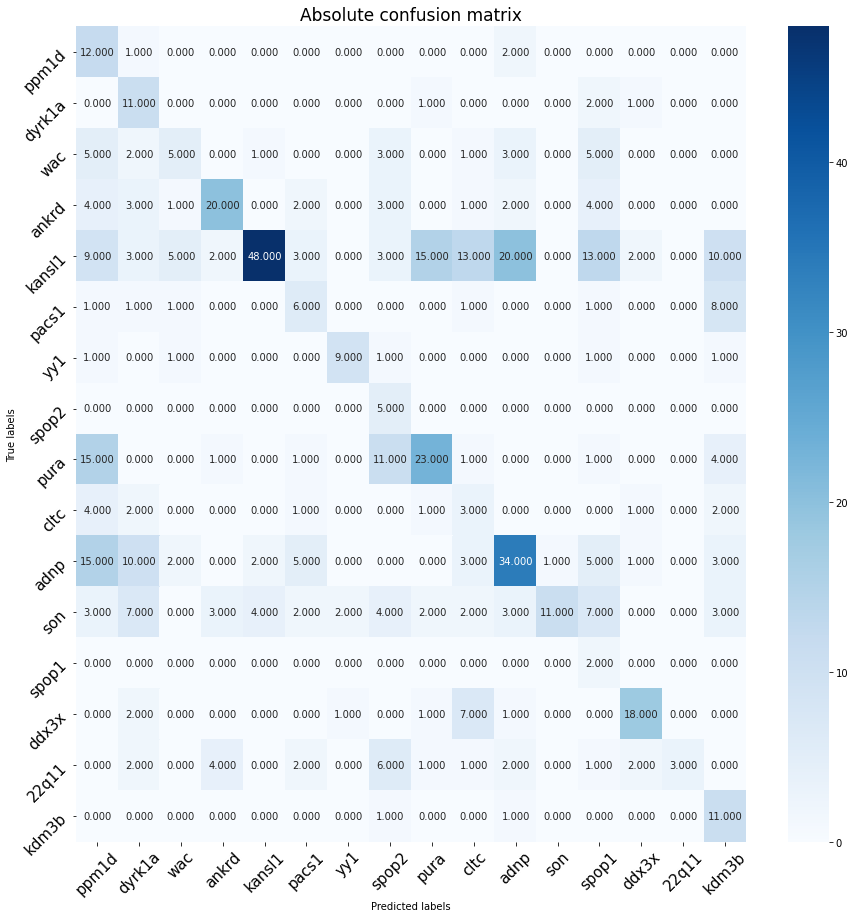

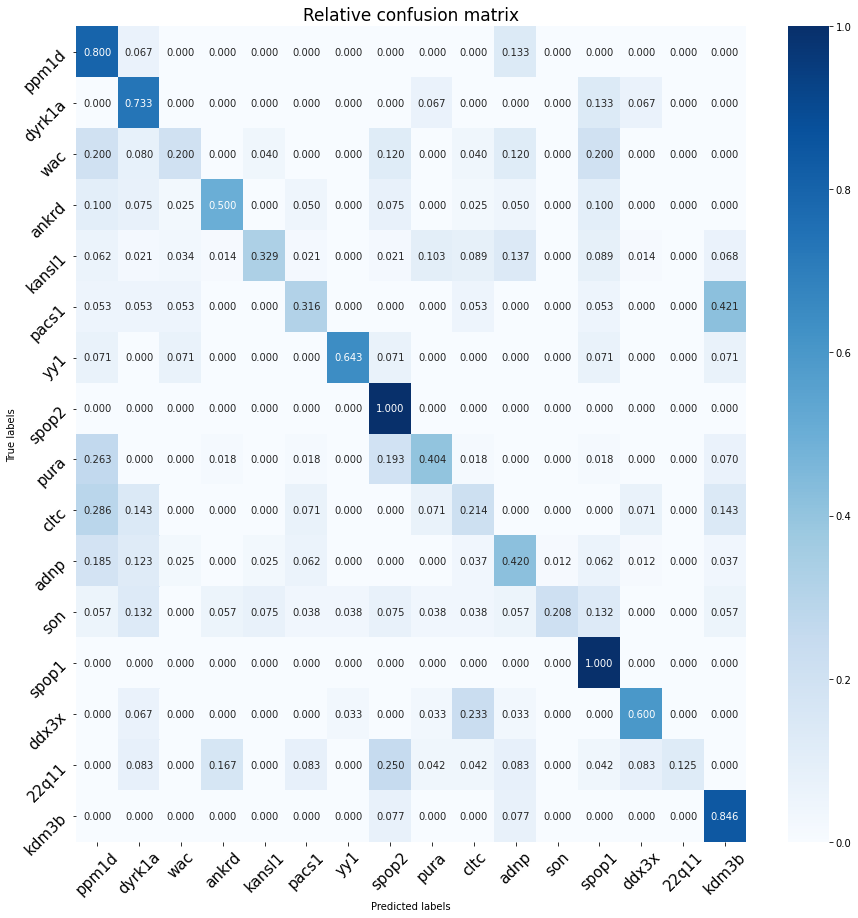

In [15]:
conf_matrix_absolute = confusion_matrix(method1_true, method1_predicted, labels = syndrome_names)
evaluator.plot_confusion_matrix(conf_matrix_absolute, syndrome_names, 'Absolute confusion matrix')

conf_matrix_relative = confusion_matrix(method1_true, method1_predicted, labels = syndrome_names, normalize = 'true')
evaluator.plot_confusion_matrix(conf_matrix_relative, syndrome_names, 'Relative confusion matrix')

# Method 2

In [44]:
method2_kfold = Method2(g['hpo_all'], g['label'], scorer, syndrome_names)

X = g['hpo_all']
y = g['label']
kf = KFold(n_splits=553, shuffle = False)

method2_individuals_predicted = []
method2_top5_predicted = []
method2_groups_predicted = []
method2_true = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    method2_true.append(y_test.values[0])
    
    method2_kfold.set_train_test_set(X_train, X_test, y_train, y_test)

    _, labels_predicted1 = method2_kfold.individuals(1)
    method2_individuals_predicted.append(labels_predicted1[0])

    _, labels_predicted2 = method2_kfold.individuals(5)
    method2_top5_predicted.append(labels_predicted2[0])
    
    _, labels_predicted3 = method2_kfold.syndrome_groups(mode = 'labels')
    method2_groups_predicted.append(labels_predicted3[0])

### Method 2a

In [17]:
evaluator.metrics(method2_true, method2_individuals_predicted)

accuracy: 0.833634719710669
f1 score - macro: 0.7434612957479301
f1 score - weighted: 0.8225482845655326


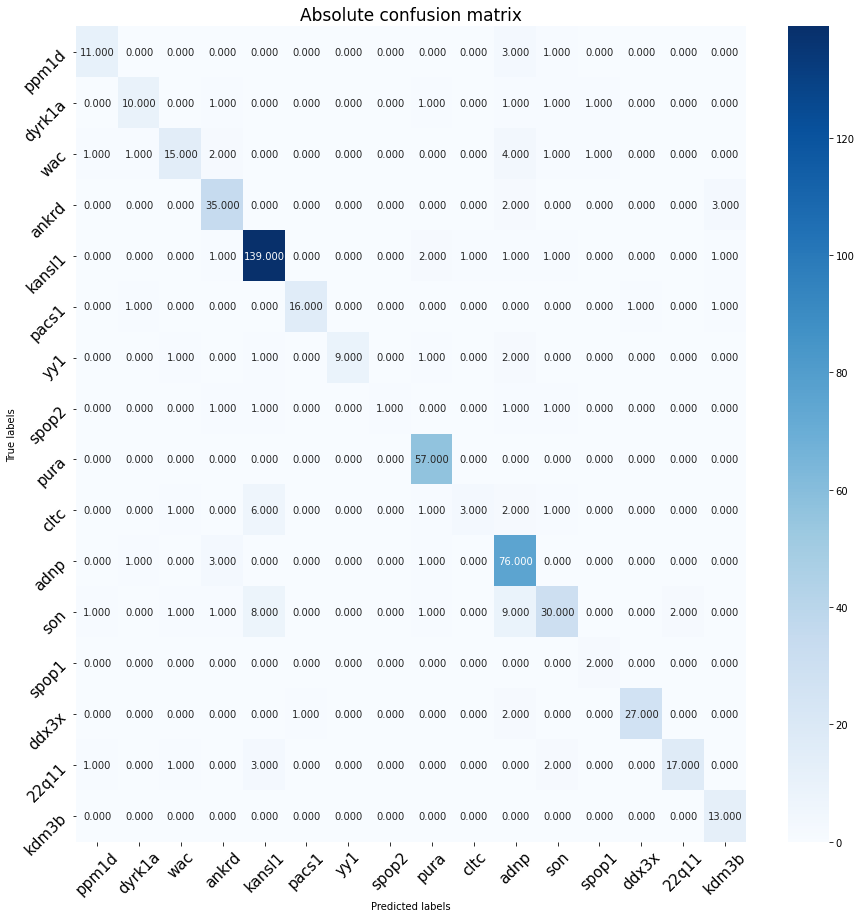

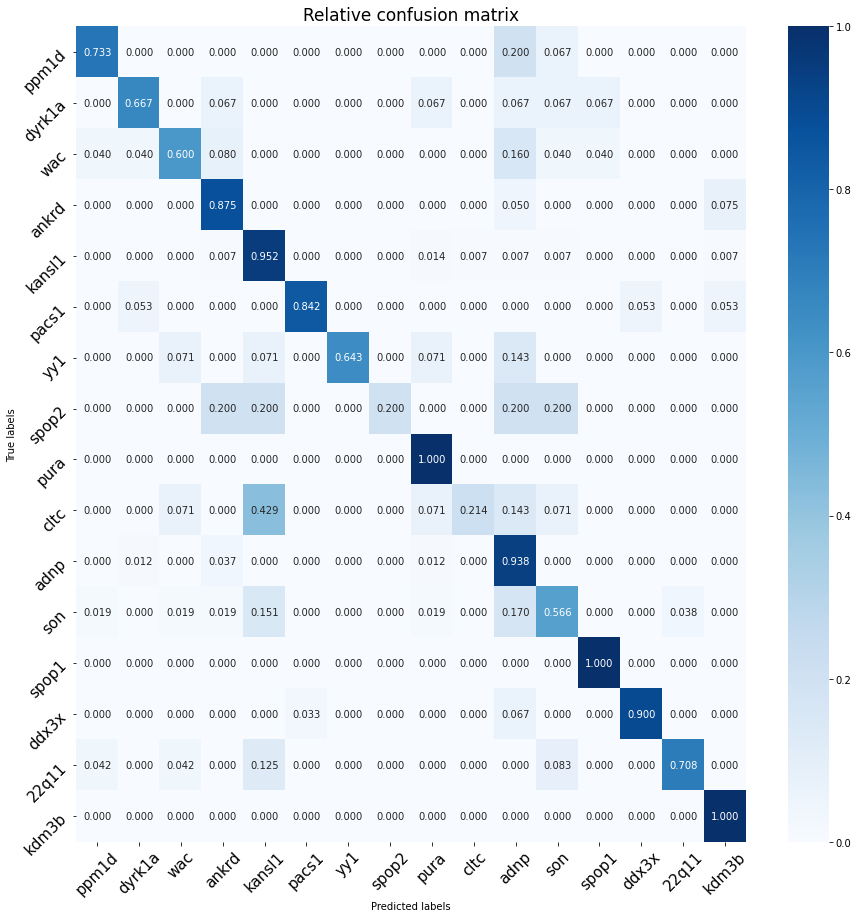

In [18]:
conf_matrix_absolute = confusion_matrix(method2_true, method2_individuals_predicted, labels = syndrome_names)
evaluator.plot_confusion_matrix(conf_matrix_absolute, syndrome_names, 'Absolute confusion matrix')

conf_matrix_relative = confusion_matrix(method2_true, method2_individuals_predicted, labels = syndrome_names, normalize = 'true')
evaluator.plot_confusion_matrix(conf_matrix_relative, syndrome_names, 'Relative confusion matrix')

### Method 2b

In [19]:
accuracy, positions, occurrences = evaluator.accuracy_topn(method2_true, method2_top5_predicted, mode = 'return')
print('accuracy:', accuracy)

accuracy: 0.9312839059674503


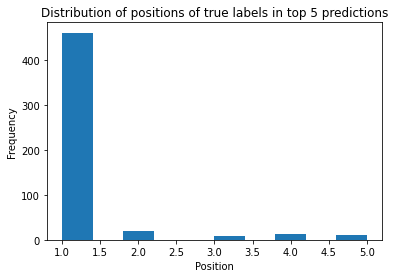

In [20]:
plt.hist(positions)
plt.ylabel("Frequency")
plt.xlabel("Position")
plt.title("Distribution of positions of true labels in top 5 predictions")
plt.show()

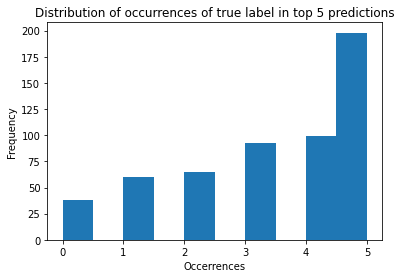

In [21]:
plt.hist(occurrences)
plt.ylabel("Frequency")
plt.xlabel("Occerrences")
plt.title("Distribution of occurrences of true label in top 5 predictions")
plt.show()

### Method 2c

In [22]:
evaluator.metrics(method2_true, method2_groups_predicted)

accuracy: 0.5479204339963833
f1 score - macro: 0.5384721375477051
f1 score - weighted: 0.612950574692732


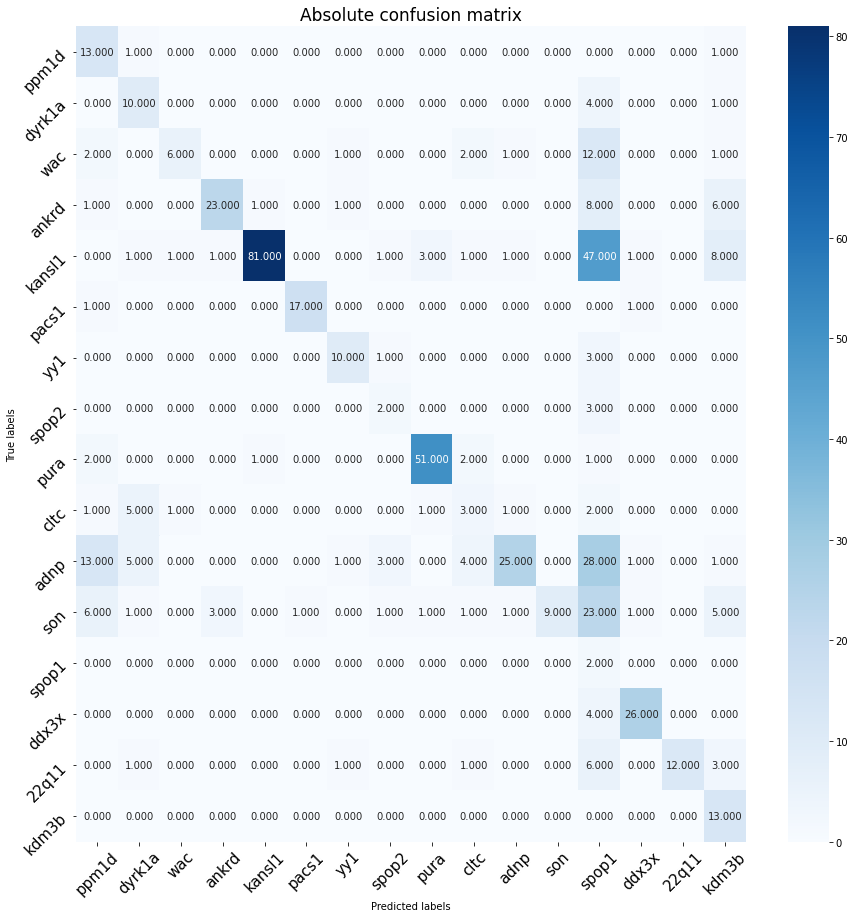

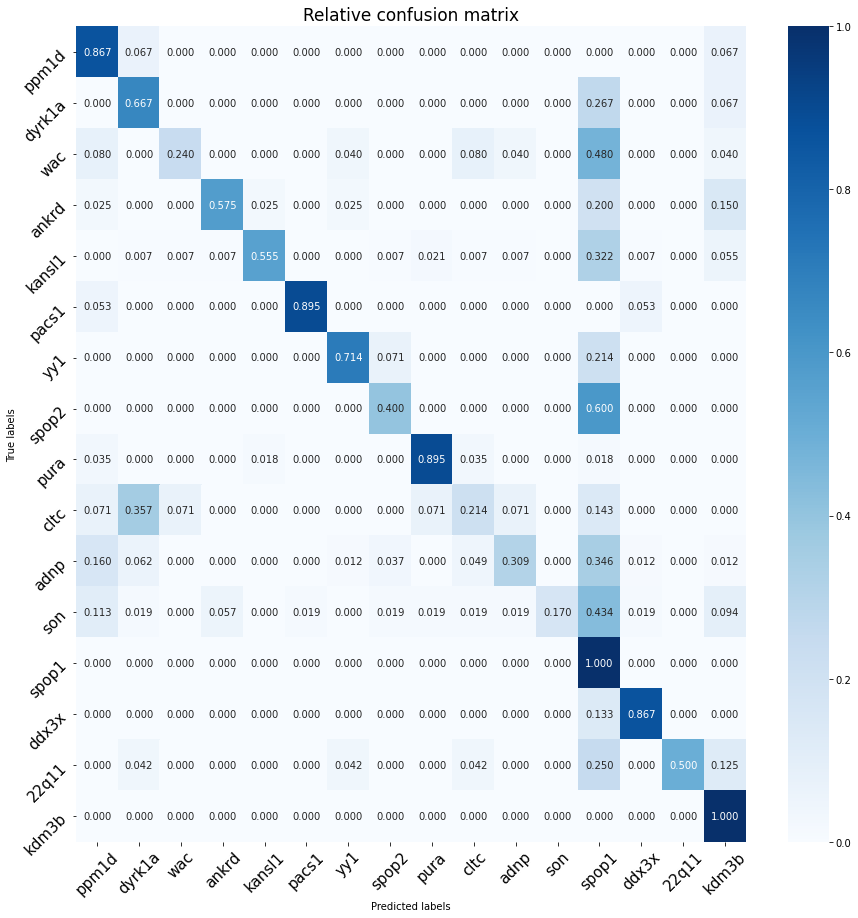

In [23]:
conf_matrix_absolute = confusion_matrix(method2_true, method2_groups_predicted, labels = syndrome_names)
evaluator.plot_confusion_matrix(conf_matrix_absolute, syndrome_names, 'Absolute confusion matrix')

conf_matrix_relative = confusion_matrix(method2_true, method2_groups_predicted, labels = syndrome_names, normalize = 'true')
evaluator.plot_confusion_matrix(conf_matrix_relative, syndrome_names, 'Relative confusion matrix')

# Ensemble methods

In [72]:
method1_ensemble = Method1(g['hpo_all'], g['label'], syndrome_profile_directory, updater, scorer, syndrome_names)
method2_ensemble = Method2(g['hpo_all'], g['label'], scorer, syndrome_names)
ensemble = EnsembleMethods()

method1_ensemble.create_dataframe_resnik()
dataframe_method1 = method1_ensemble.get_dataframe()
_, labelstop3_method1 = method1_ensemble.top_n_predictions(3)

/home/sasja/.local/lib/python3.8/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [73]:
method2_ensemble = Method2(g['hpo_all'], g['label'], scorer, syndrome_names)

In [74]:
ensemble1_predicted = []
ensemble2_predicted = []
ensemble_true = []

X = g['hpo_all']
y = g['label']
kf = KFold(n_splits=553, shuffle = False)

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    ensemble_true.append(y_test.values[0])
    
    method1_df = dataframe_method1[test_index[0]:test_index[0]+1]
    method1_df.reset_index(drop=True, inplace=True)
    
    method2_ensemble.set_train_test_set(X_train, X_test, y_train, y_test)
    method2_dict = method2_ensemble.syndrome_groups(mode = 'dict')
    method2_df = pd.DataFrame(method2_dict)
    method2_df.reset_index(drop=True, inplace=True)

    ensemble_df = ensemble.merge_dataframes(method1_df, method2_df)
    _, predicted_labels1 = method1_ensemble.predict_labels(ensemble_df)
    ensemble1_predicted.append(predicted_labels1)
    
    method1_top3 = labelstop3_method1[test_index[0]]
    _, method2_top3 = method2_ensemble.individuals(3)
    predicted_labels2 = ensemble.predict_labels_topn({0:method1_top3}, method2_top3)
    ensemble2_predicted.append(predicted_labels2)

### Ensemble method 1

In [84]:
evaluator.metrics(ensemble_true, ensemble1_predicted)

accuracy: 0.5262206148282098
f1 score - macro: 0.5283325618425507
f1 score - weighted: 0.577836984254096


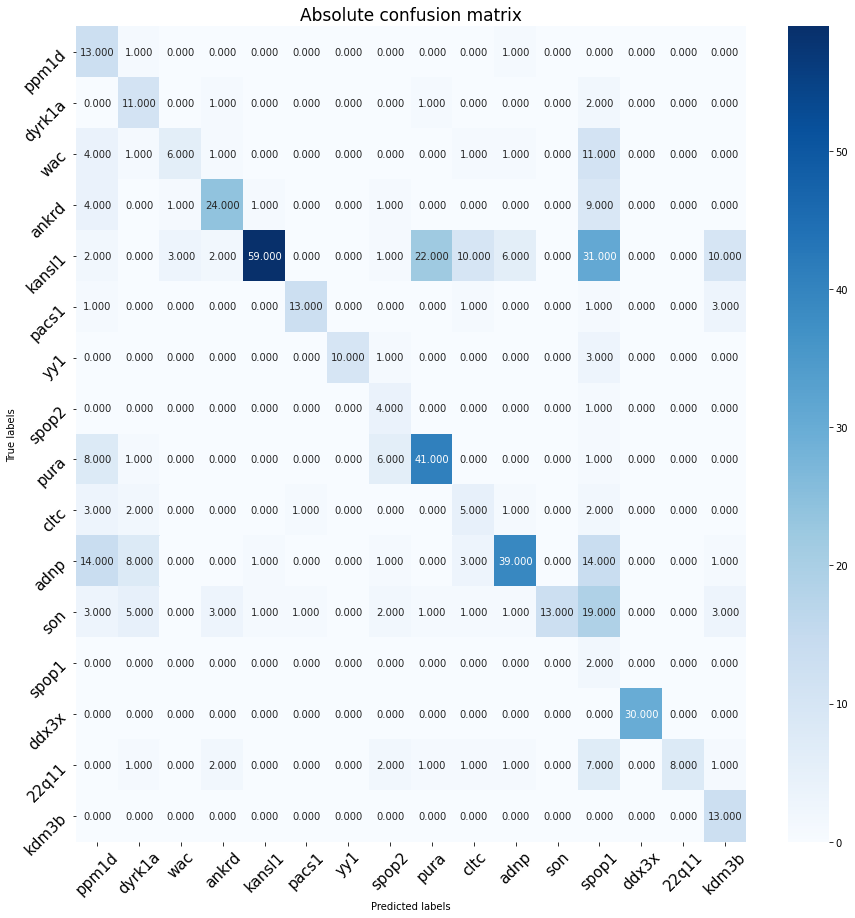

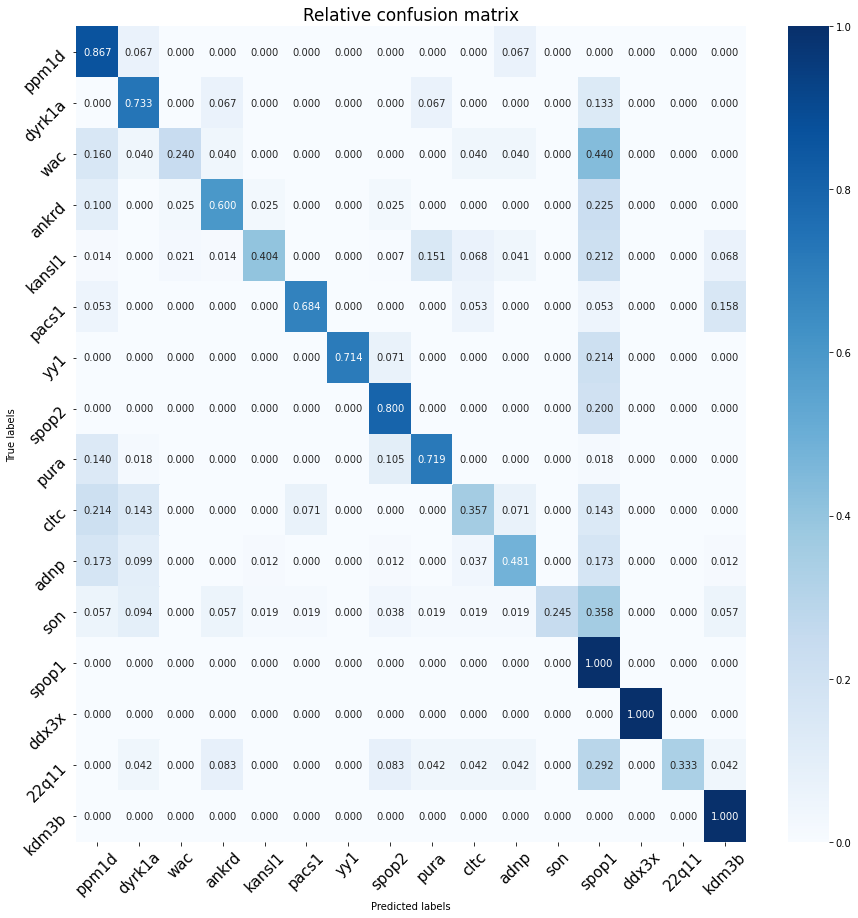

In [85]:
conf_matrix_absolute = confusion_matrix(ensemble_true, ensemble1_predicted, labels = syndrome_names)
evaluator.plot_confusion_matrix(conf_matrix_absolute, syndrome_names, 'Absolute confusion matrix')

conf_matrix_relative = confusion_matrix(ensemble_true, ensemble1_predicted, labels = syndrome_names, normalize = 'true')
evaluator.plot_confusion_matrix(conf_matrix_relative, syndrome_names, 'Relative confusion matrix')

### Ensemble Method 2

In [86]:
evaluator.metrics(ensemble_true, ensemble2_predicted)

accuracy: 0.8119349005424955
f1 score - macro: 0.7219955721606002
f1 score - weighted: 0.8044700855368607


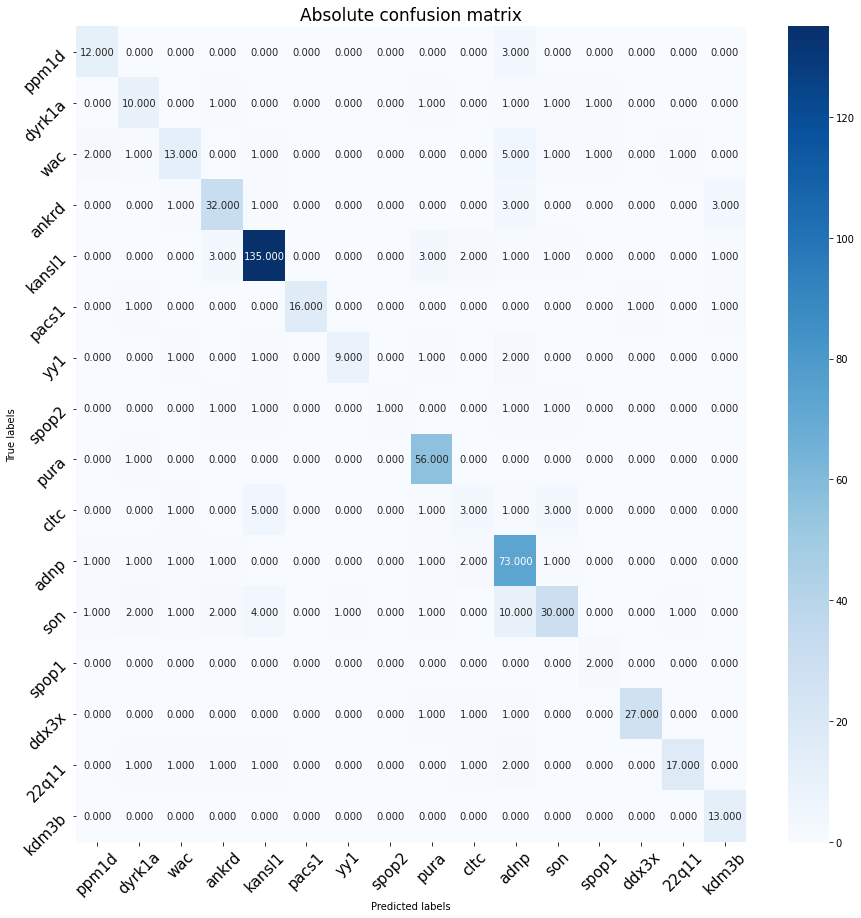

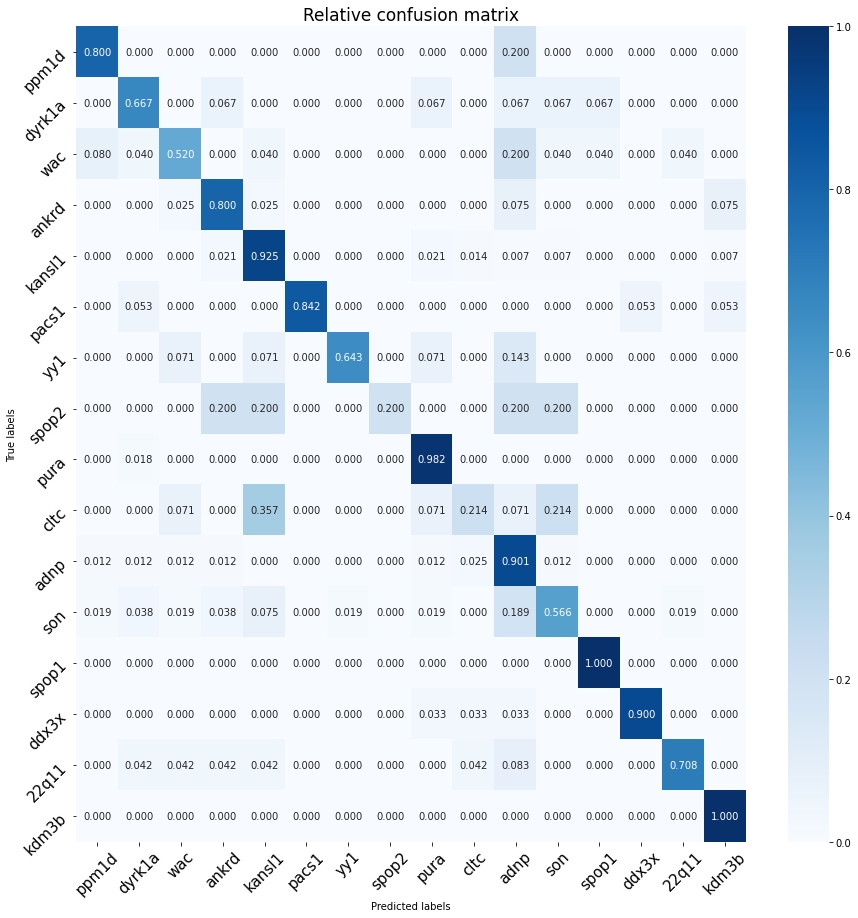

In [87]:
conf_matrix_absolute = confusion_matrix(ensemble_true, ensemble2_predicted, labels = syndrome_names)
evaluator.plot_confusion_matrix(conf_matrix_absolute, syndrome_names, 'Absolute confusion matrix')

conf_matrix_relative = confusion_matrix(ensemble_true, ensemble2_predicted, labels = syndrome_names, normalize = 'true')
evaluator.plot_confusion_matrix(conf_matrix_relative, syndrome_names, 'Relative confusion matrix')

# Overview methods

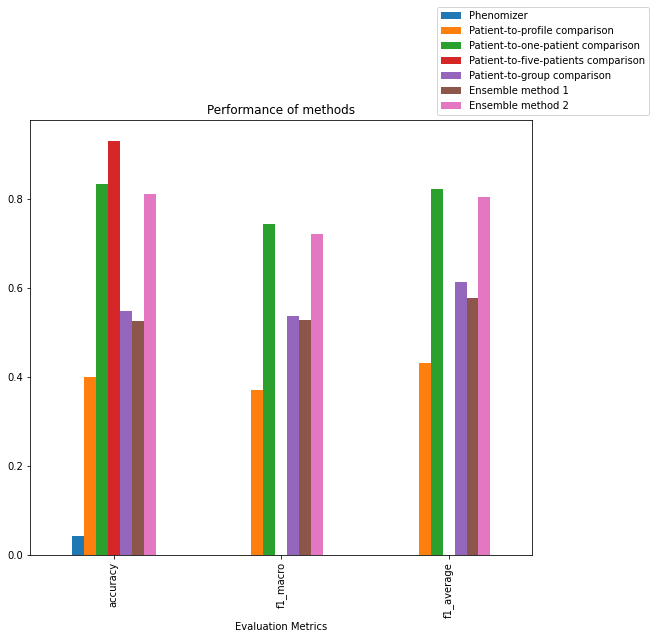

In [102]:
data = [['accuracy', .042, .400, .834, .931, .548, .526, .812],
        ['f1_macro', 0, .370, .743, 0, .538, .528, .722],
        ['f1_average', 0, .431, .823, 0, .613, .578, .804]]

df=pd.DataFrame(data,columns=["Evaluation Metrics",'Phenomizer', "Patient-to-profile comparison", "Patient-to-one-patient comparison", 'Patient-to-five-patients comparison', 'Patient-to-group comparison', 'Ensemble method 1', 'Ensemble method 2'])
df.plot(x="Evaluation Metrics", y=["Phenomizer", "Patient-to-profile comparison", "Patient-to-one-patient comparison", 'Patient-to-five-patients comparison', 'Patient-to-group comparison', 'Ensemble method 1', 'Ensemble method 2'], kind="bar",figsize=(9,8))
plt.title("Performance of methods")
plt.legend(loc="lower left",bbox_to_anchor=(0.8,1.0))
plt.show()

# Significance

In [95]:
t1t2a, t1f2a, f1t2a, f1f2a = 0, 0, 0, 0
t1t2c, t1f2c, f1t2c, f1f2c = 0, 0, 0, 0
t1te1, t1fe1, f1te1, f1fe1 = 0, 0, 0, 0
t1te2, t1fe2, f1te2, f1fe2 = 0, 0, 0, 0


for i in range(len(method1_true)):
    if method1_predicted[i] == method1_true[i]:
        if method2_individuals_predicted[i] == method2_true[i]:
            t1t2a += 1
        else:
            t1f2a += 1
            
        if method2_groups_predicted[i] == method2_true[i]:
            t1t2c += 1
        else:
            t1f2c += 1
            
        if ensemble1_predicted[i][0] == ensemble_true[i]:
            t1te1 += 1
        else:
            t1fe1 += 1
            
        if ensemble2_predicted[i][0] == ensemble_true[i]:
            t1te2 += 1
        else:
            t1fe2 += 1

    else: 
        if method2_individuals_predicted[i] == method2_true[i]:
            f1t2a += 1
        else:
            f1f2a += 1
        
        if method2_groups_predicted[i] == method2_true[i]:
            f1t2c += 1
        else:
            f1f2c += 1
            
        if ensemble1_predicted[i][0] == ensemble_true[i]:
            f1te1 += 1
        else:
            f1fe1 += 1
            
        if ensemble2_predicted[i][0] == ensemble_true[i]:
            f1te2 += 1
        else:
            f1fe2 += 1

In [96]:
method1_2a_contingency = [[t1t2a, t1f2a],[f1t2a,f1f2a]]
method1_2c_contingency = [[t1t2c, t1f2c],[f1t2c,f1f2c]]
method1_ensemble1_contingency = [[t1te1, t1fe1],[f1te1,f1fe1]]
method1_ensemble2_contingency = [[t1te2, t1fe2],[f1te2,f1fe2]]

In [98]:
from statsmodels.stats.contingency_tables import mcnemar
print("Model1 and Model2a :\n", mcnemar(method1_2a_contingency, exact=False, correction=True))
print("Model1 and Model2c :\n", mcnemar(method1_2c_contingency, exact=False, correction=True))
print("Model1 and Ensemble1 :\n", mcnemar(method1_ensemble2_contingency, exact=False, correction=True))
print("Model1 and Ensemble2 :\n", mcnemar(method1_ensemble2_contingency, exact=False, correction=True))

Model1 and Model2a :
 pvalue      1.3364935079949343e-46
statistic   205.47122302158274
Model1 and Model2c :
 pvalue      6.231071332321525e-08
statistic   29.290178571428573
Model1 and Ensemble1 :
 pvalue      1.1100080464634352e-44
statistic   196.67557251908397
Model1 and Ensemble2 :
 pvalue      1.1100080464634352e-44
statistic   196.67557251908397
